## A CE09OSPM Temperature and Salinity Climatology
### Summary:
This script uses the OOI UFrame M2M API to synchronously download CE09OSPM ([Washington Offshore Profiler Mooring](https://oceanobservatories.org/site/ce09ospm/)) data for Oct 2014 - July 2018. The script bins the data into one meter bins and calculates monthly mean profiles for each month for this 46 month period. Due to the relatively short time series, climatologies are calculated using harmonic analysis rather than computing long-term means for each of the 12 calendar months from the arithmetic average of all available observations in each month. Finally plots of the climatologies, data and anomalies are generated.

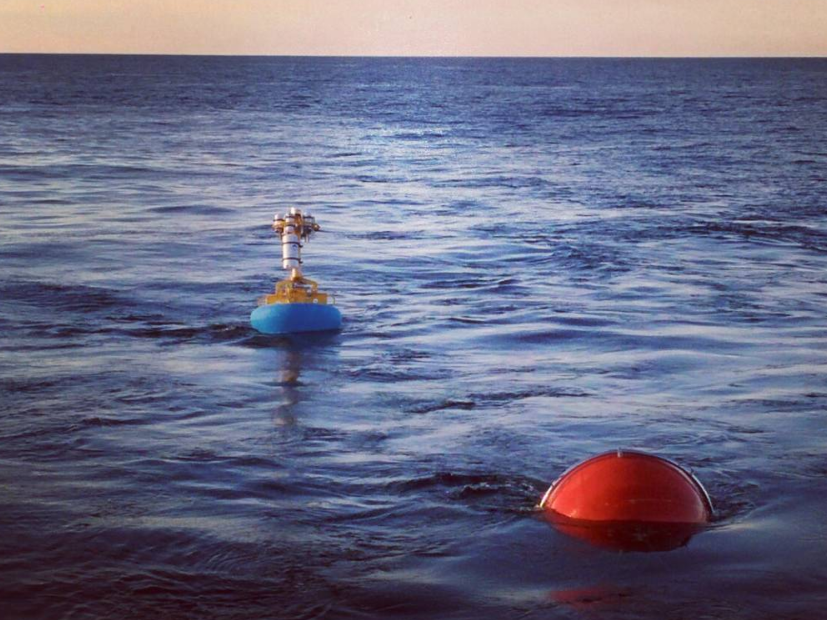

In [50]:
USERNAME = 'OOIAPI-T4K9H80QN79JPD'
TOKEN =  '2QXI1W549EC1EU'

# import python packages
import requests
import datetime
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
import calendar

import warnings
warnings.filterwarnings("ignore")  #this turns of the nanmean warning

SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

r = requests.get(SENSOR_BASE_URL, auth=(USERNAME, TOKEN))
  
# function to make an API request and print the results
def get_and_print_api(url):
  r = requests.get(url, auth=(USERNAME, TOKEN))
  data = r.json()
  for d in data:
    print( d )

ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
   return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)


In [51]:
temp_binned = np.zeros((510, 51))
salt_binned = np.zeros((510, 51))

kk=-1

for i in range(2014, 2019, 1):
    
    if i == 2014:
        mm=10
    else:
        mm=1
    
    for j in range(mm, 13, 1):
        
        if i == 2018 and j >= 3:
            # Instrument Information
            site = 'CE09OSPM'
            node = 'WFP01'
            instrument = '03-CTDPFK000'
            method = 'telemetered'
            stream = 'ctdpf_ckl_wfp_instrument'
        else:
            # Instrument Information
            site = 'CE09OSPM'
            node = 'WFP01'
            instrument = '03-CTDPFK000'
            method = 'recovered_wfp'
            stream = 'ctdpf_ckl_wfp_instrument_recovered'
    
        #figure out the number of days in each month to set endDT below
        start_date = date(i,j,1)
        days_in_month = calendar.monthrange(start_date.year, start_date.month)[1]
        
        if j < 10:
            month='0'+str(j)
        else:
            month=str(j)
        
        params = {
          'beginDT':str(i)+'-'+month+'-01T00:00:00.000Z',
          'endDT':str(i)+'-'+month+'-'+str(days_in_month)+'T23:59:59.000Z',
          'limit':20000,   
        }
        
        #request all the data for a particular month
        data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))
        r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
        data = r.json()
        
        # if statement to check if there is any data
        if len(data) == 2:
           print('no data for '+str(i)+'-'+month)
           kk=kk+1
        else:
           print('found some data for '+str(i)+'-'+month)
           # Time Processing Routine
           #ntp_epoch = datetime.datetime(1900, 1, 1)
           #unix_epoch = datetime.datetime(1970, 1, 1)
           #ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

           time = []
           pressure = []
           temperature = []
           salinity = []

           # pull the data out of the JSON repsonse and into the appropriate var 
           for xx in range(len(data)):
             time.append(ntp_seconds_to_datetime(data[xx]['time']))
             pressure.append(data[xx]['ctdpf_ckl_seawater_pressure'])
             temperature.append(data[xx]['ctdpf_ckl_seawater_temperature'])
             salinity.append(data[xx]['practical_salinity'])

           #convert from lists to np arrays
           temperature=np.array(temperature)
           pressure=np.array(pressure)
           salinity=np.array(salinity)
        
           #bin the data
           bins = np.arange(511)   #1m bins; at 25cm/s ~ 4obs/1m bin
           temp_array = np.zeros((len(bins)-1,))
           temp_array[temp_array == 0.0] = np.nan
           salt_array = np.zeros((len(bins)-1,))
           salt_array[salt_array == 0.0] = np.nan
           
           k=-1
           for ii in range(len(bins)-1):
               ind = np.where((pressure >= bins[ii]) & (pressure < bins[ii+1]))
               k=k+1
               temp_array[k] = np.nanmean(temperature[ind])
               salt_array[k] = np.nanmean(salinity[ind])

           kk=kk+1
           temp_binned[:,kk]=temp_array
           salt_binned[:,kk]=salt_array

temp_binned[temp_binned == 0.0] = np.nan
salt_binned[salt_binned == 0.0] = np.nan
temp_binned=temp_binned[:,0:46] #Oct 2014 - July 2018
salt_binned=salt_binned[:,0:46]

found some data for 2014-10
found some data for 2014-11
found some data for 2014-12
found some data for 2015-01
found some data for 2015-02
found some data for 2015-03
found some data for 2015-04
found some data for 2015-05
found some data for 2015-06
found some data for 2015-07
found some data for 2015-08
found some data for 2015-09
found some data for 2015-10
found some data for 2015-11
found some data for 2015-12
found some data for 2016-01
found some data for 2016-02
found some data for 2016-03
found some data for 2016-04
found some data for 2016-05
found some data for 2016-06
found some data for 2016-07
found some data for 2016-08
found some data for 2016-09
no data for 2016-10
no data for 2016-11
no data for 2016-12
no data for 2017-01
no data for 2017-02
no data for 2017-03
found some data for 2017-04
found some data for 2017-05
found some data for 2017-06
found some data for 2017-07
found some data for 2017-08
found some data for 2017-09
found some data for 2017-10
found some d

#### Now we calculate the climatologies based on the monthly mean values

In [52]:
#get array dims
[x,y]=np.shape(temp_binned)
#these are monthly data so f=1/12
f=1./12.

temp_beta_values = np.zeros((x,9))

#now start calculating a temperature climatology for each of the 510 bin depths
for i in range(0, x):
    c = np.squeeze(temp_binned[i,:])
    t = np.arange(0, y)
    #remove the nans
    t = t[~np.isnan(c)]
    c = c[~np.isnan(c)]
    
    N=len(c)
        
    if N == 0:
        temp_beta_values[i,:] = np.nan
    else:
        X=[np.ones(N),np.sin(2*np.pi*f*t),np.cos(2*np.pi*f*t),np.sin(4*np.pi*f*t),np.cos(4*np.pi*f*t),np.sin(6*np.pi*f*t),np.cos(6*np.pi*f*t),np.sin(8*np.pi*f*t),np.cos(8*np.pi*f*t)]
        [b,residues,rank,s] = np.linalg.lstsq(np.transpose(X),c,rcond=-1)
        temp_beta_values[i,:] = b


salt_beta_values = np.zeros((x,9))

#now start calculating a salinity climatology for each of the 510 bin depths
for i in range(0, x):
    c = np.squeeze(salt_binned[i,:])
    t = np.arange(0, y)
    #remove the nans
    t = t[~np.isnan(c)]
    c = c[~np.isnan(c)]
    
    N=len(c)
        
    if N == 0:
        salt_beta_values[i,:] = np.nan
    else:
        X=[np.ones(N),np.sin(2*np.pi*f*t),np.cos(2*np.pi*f*t),np.sin(4*np.pi*f*t),np.cos(4*np.pi*f*t),np.sin(6*np.pi*f*t),np.cos(6*np.pi*f*t),np.sin(8*np.pi*f*t),np.cos(8*np.pi*f*t)]
        [b,residues,rank,s] = np.linalg.lstsq(np.transpose(X),c,rcond=-1)
        salt_beta_values[i,:] = b

new_t=np.arange(0, y)
temp_seasonal_cycle = np.zeros((x,y))

for i in range(0, x):
        T=(temp_beta_values[i,0]+temp_beta_values[i,1]*np.sin(2.*np.pi*f*new_t)+temp_beta_values[i,2]*np.cos(2.*np.pi*f*new_t)+temp_beta_values[i,3]*np.sin(4.*np.pi*f*new_t)+temp_beta_values[i,4]*np.cos(4.*np.pi*f*new_t))
        temp_seasonal_cycle[i,:] = T

new_t=np.arange(0, y)
salt_seasonal_cycle = np.zeros((x,y))

for i in range(0, x):
        T=(salt_beta_values[i,0]+salt_beta_values[i,1]*np.sin(2.*np.pi*f*new_t)+salt_beta_values[i,2]*np.cos(2.*np.pi*f*new_t)+salt_beta_values[i,3]*np.sin(4.*np.pi*f*new_t)+salt_beta_values[i,4]*np.cos(4.*np.pi*f*new_t))
        salt_seasonal_cycle[i,:] = T

temp_seasonal_cycle[0:30,:]=np.nan #nan out data above 30 meters where tere is to little data to calculate a decent climatology
salt_seasonal_cycle[0:30,:]=np.nan

#shift the matrices such that the first column is Jan and the last is Dec
temp_seasonal_cycle_jan_dec = np.zeros((510, 12))
temp_seasonal_cycle_jan_dec[:,0:9]=temp_seasonal_cycle[:,3:12]
temp_seasonal_cycle_jan_dec[:,9:12]=temp_seasonal_cycle[:,0:3]

salt_seasonal_cycle_jan_dec = np.zeros((510, 12))
salt_seasonal_cycle_jan_dec[:,0:9]=salt_seasonal_cycle[:,3:12]
salt_seasonal_cycle_jan_dec[:,9:12]=salt_seasonal_cycle[:,0:3]


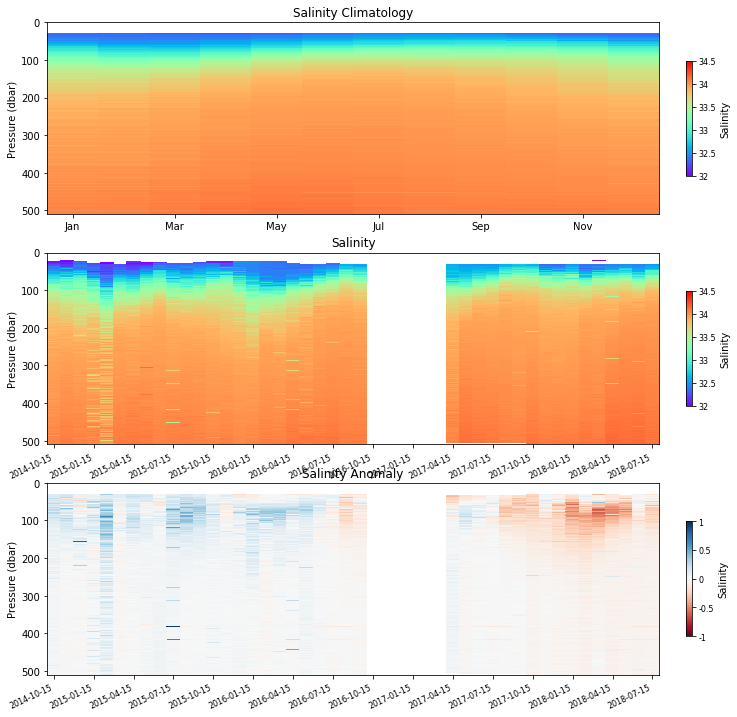

In [55]:
x=np.arange(0, y)+.5
#generate time stamp list for plots
k=-1
time_stamp=[]
for i in range(2014, 2019, 1):        
    for j in range(1, 13, 1):
        k=k+1
        time_stamp.append(date(i,j,15))

time_stamp=time_stamp[9:55]

#plot some stuff
fig = plt.figure(figsize=(12,12))
plt.subplot(311)
cax = plt.pcolor(salt_seasonal_cycle_jan_dec, vmin=32, vmax=34.5, cmap='rainbow')
plt.gca().invert_yaxis()
plt.xticks([0.5, 2.5, 4.5, 6.5, 8.5, 10.5], ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov'])
plt.ylabel('Pressure (dbar)')
plt.title('Salinity Climatology')
#deal with the colorbar
cbar = fig.colorbar(cax, ticks=[32,32.5,33,33.5,34,34.5], fraction=0.046, pad=0.04, shrink=.6)
cbar.ax.set_yticklabels([32,32.5,33,33.5,34,34.5], fontsize=8)  # vertically oriented colorbar
cbar.ax.set_ylabel('Salinity', rotation=90, fontsize=10)

#plot some anomaly stuff
plt.subplot(312)
cax = plt.pcolor(salt_binned, vmin=32, vmax=34.5, cmap='rainbow')
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.title('Salinity')
#deal with the colorbar
cbar = fig.colorbar(cax, ticks=[32,32.5,33,33.5,34,34.5], fraction=0.046, pad=0.04, shrink=.6)
cbar.ax.set_yticklabels([32,32.5,33,33.5,34,34.5], fontsize=8)  # vertically oriented colorbar
cbar.ax.set_ylabel('Salinity', rotation=90, fontsize=10)
#label stuff
plt.xticks(x[::3], time_stamp[::3], rotation=25, horizontalalignment='right', fontsize=8)
plt.tick_params(axis="x", labelcolor="k", pad=4)

#plot some anomaly stuff
plt.subplot(313)
cax = plt.pcolor(salt_seasonal_cycle-salt_binned, vmin=-1, vmax=1, cmap='RdBu')
plt.gca().invert_yaxis()
#plt.xticks([0.5, 2.5, 4.5, 6.5, 8.5, 10.5], ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov'])
plt.ylabel('Pressure (dbar)')
plt.title('Salinity Anomaly')
#deal with the colorbar
cbar = fig.colorbar(cax, ticks=[-1, -.5, 0, .5, 1], fraction=0.046, pad=0.04, shrink=.6)
cbar.ax.set_yticklabels([-1, -.5, 0, .5, 1], fontsize=8)  # vertically oriented colorbar
cbar.ax.set_ylabel('Salinity', rotation=90, fontsize=10)
ax = plt.gca()
#label stuff
plt.xticks(x[::3], time_stamp[::3], rotation=25, horizontalalignment='right', fontsize=8)
plt.tick_params(axis="x", labelcolor="k", pad=4)

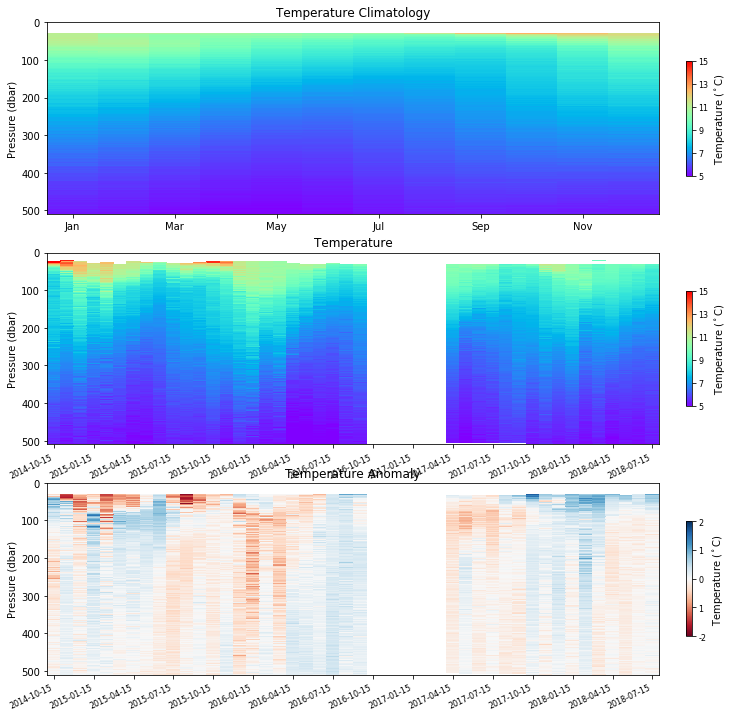

In [56]:
#plot some stuff
fig = plt.figure(figsize=(12,12))
plt.subplot(311)
cax = plt.pcolor(temp_seasonal_cycle_jan_dec, vmin=5, vmax=15, cmap='rainbow')
plt.gca().invert_yaxis()
plt.xticks([0.5, 2.5, 4.5, 6.5, 8.5, 10.5], ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov'])
plt.ylabel('Pressure (dbar)')
plt.title('Temperature Climatology')
#deal with the colorbar
cbar = fig.colorbar(cax, ticks=[5,7,9,11,13,15], fraction=0.046, pad=0.04, shrink=.6)
cbar.ax.set_yticklabels([5,7,9,11,13,15], fontsize=8)  # vertically oriented colorbar
cbar.ax.set_ylabel('Temperature ($^\circ$C)', rotation=90, fontsize=10)

#plot some anomaly stuff
plt.subplot(312)
cax = plt.pcolor(temp_binned, vmin=5, vmax=15, cmap='rainbow')
plt.gca().invert_yaxis()
#plt.xticks([0.5, 2.5, 4.5, 6.5, 8.5, 10.5], ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov'])
plt.ylabel('Pressure (dbar)')
plt.title('Temperature')
#deal with the colorbar
cbar = fig.colorbar(cax, ticks=[5,7,9,11,13,15], fraction=0.046, pad=0.04, shrink=.6)
cbar.ax.set_yticklabels([5,7,9,11,13,15], fontsize=8)  # vertically oriented colorbar
cbar.ax.set_ylabel('Temperature ($^\circ$C)', rotation=90, fontsize=10)
#label stuff
plt.xticks(x[::3], time_stamp[::3], rotation=25, horizontalalignment='right', fontsize=8)
plt.tick_params(axis="x", labelcolor="k", pad=4)

#plot some anomaly stuff
plt.subplot(313)
cax = plt.pcolor(temp_seasonal_cycle-temp_binned, vmin=-2, vmax=2, cmap='RdBu')
plt.gca().invert_yaxis()
#plt.xticks([0.5, 2.5, 4.5, 6.5, 8.5, 10.5], ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov'])
plt.ylabel('Pressure (dbar)')
plt.title('Temperature Anomaly')
#deal with the colorbar
cbar = fig.colorbar(cax, ticks=[-2, -1, 0, 1, 2], fraction=0.046, pad=0.04, shrink=.6)
cbar.ax.set_yticklabels([-2, 1, 0, 1, 2], fontsize=8)  # vertically oriented colorbar
cbar.ax.set_ylabel('Temperature ($^\circ$C)', rotation=90, fontsize=10)
ax = plt.gca()
#label stuff
plt.xticks(x[::3], time_stamp[::3], rotation=25, horizontalalignment='right', fontsize=8)
plt.tick_params(axis="x", labelcolor="k", pad=4)

fin


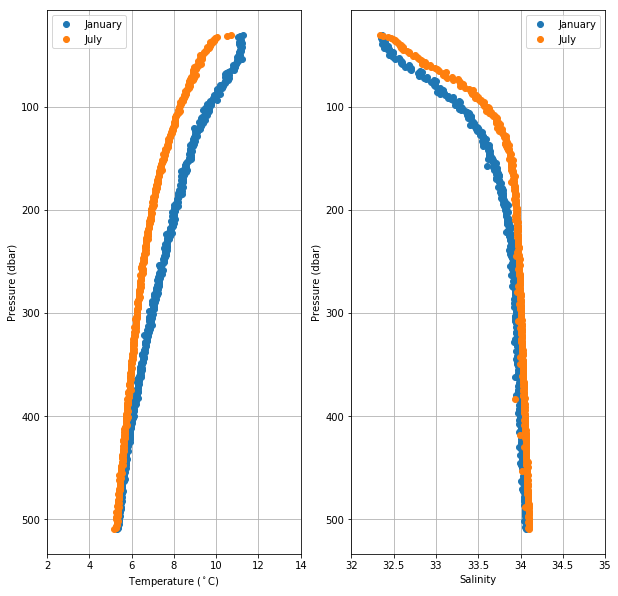

In [60]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121)
plt.plot_date(temp_seasonal_cycle_jan_dec[:,0],bins[1:]-.5, label='January')
plt.plot_date(temp_seasonal_cycle_jan_dec[:,6],bins[1:]-.5, label='July')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left')
ax.grid('on')
plt.gca().invert_yaxis()
plt.xlim(4,12)
plt.xticks([2, 4, 6, 8, 10, 12, 14], [2, 4, 6, 8, 10, 12, 14])
plt.ylabel('Pressure (dbar)')
plt.xlabel('Temperature ($^\circ$C)')

ax = fig.add_subplot(122)
plt.plot_date(salt_seasonal_cycle_jan_dec[:,0],bins[1:]-.5, label='January')
plt.plot_date(salt_seasonal_cycle_jan_dec[:,6],bins[1:]-.5, label='July')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper right')
ax.grid('on')
plt.gca().invert_yaxis()
plt.xlim(32,35)
plt.xticks([32, 32.5, 33, 33.5, 34, 34.5, 35], [32, 32.5, 33, 33.5, 34, 34.5, 35])
plt.ylabel('Pressure (dbar)')
plt.xlabel('Salinity')

print('fin')